**Table of Contents**

>[About task:](#scrollTo=ZI07bRpQzEbb)

>[Required Libraries](#scrollTo=t8jPt_yS-7LK)

>[MNIST dataset](#scrollTo=C4DzA9NTzX38)

>[Quantum Circuit as a Convolutional Layer](#scrollTo=qkeaSKTN_jB9)

>[Hybrid quantum-classical model](#scrollTo=R1CrqWrozX4D)

>>[Training (Hybrid Model)](#scrollTo=30XGS5aezX4E)

>>>[Performance Measurements](#scrollTo=tzp2l9a7Cv22)

>>[Training (Classical Model)](#scrollTo=b5T9fw3n_PJy)

>>>[Performance Measurements](#scrollTo=FGGYNAo-C17_)

>>[Model Comparison](#scrollTo=HlGocvUMzX4F)

>[References](#scrollTo=xxQ2tCubxN0v)



# About task:
This notebook is an adaptation of the referenced notebook. My contributions include:
- **3x3 kernel**: Implemented a 3x3 kernel for the Quantum Convolutional layer. As the 3x3 kernel has 9 elements. So I needed a 9-qubit system.

- **Ansatz(e):** 4 Strongly Entangling layers(with CZ as imprimitive) are used as ansatze. A 1 layer system could do the work, but as I see in task_4, more layers give access to more Hilbert space, leading to lower cost and better accuracy.

- **Custom hybrid model:** The quantum circuit is used as a convolutional layer and produced 15x15x9 dimension of features. Which is then fed to the classical CNN. For the classical part, a Convolutional 3x3 kernel with 32 channels, followed by a maxpooling2D 2x2 filter is implemented. A dense layer with 64 nodes is applied before the 10 classifying dense nodes, and a dropout of 50% is imposed in the middle to handle the overfitting issue.

- **Dataset:** The actual dataset contains 10 classes of 60,000 training data and 10,000 testing data. As resource constraints, 350 data are used to train the model from the actual training set, and 50 and 100 data for validation and testing, respectively, from the testing set.

- **Hyperparameter tuning:** The model was started to train with a 0.001 learning rate. The ReduceLROnPlateau method is used to reduce the learning rate by 20% if no minimized validation loss is found for 3 consecutive epochs. Also, ImageDataGenerator from tensorflow-preprocessing is used to help the tuning process.

- **Performance comparison:** Performed Overall Accuracy(OA), Average Accuracy(AA), and Kappa Score measurement on the models. For the classical-quantum hybrid model, the overall, average, and kappa score is found to be 88%, 90.25%, and 86.6086% respectively(on 100 testing data). For the classical model, the metrics are 88%, 87.81%, and 86.6012% respectively(on 100 testing data). Though these metrics are almost equal, the hybrid model performed well on validation data.

# Required Libraries

In [ ]:
!pip install pennylane -q

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import pi

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau, CSVLogger

from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# configs
n_epochs = 50   # Number of optimization epochs
n_layers = 4    # Number of layers
n_train = 350    # Size of the train dataset
n_test = 100     # Size of the test dataset
n_val = 50     # Size of the validation dataset
batch_size = 32
exp_name = 'task_3'
root_path = "/content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_3/"  # Data saving folder

if not os.path.exists(root_path):
    os.mkdir(root_path)

PREPROCESS = False           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

# MNIST dataset

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Shuffling the dataset
from sklearn.utils import shuffle
Xtrain_images, ytrain_labels = shuffle(train_images, train_labels, random_state=0)
Xtest_images, ytest_labels = shuffle(test_images, test_labels, random_state=0)

# Reduce dataset size
train_images = Xtrain_images[:n_train]
train_labels = ytrain_labels[:n_train]

# for final testing
test_images = Xtest_images[:n_test]
test_labels = ytest_labels[:n_test]

# while training, a small set to check how the model performs
val_images = Xtest_images[n_test: n_test+n_val]
val_labels = ytest_labels[n_test: n_test+n_val]

# Normalize pixel values within 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0
val_images = val_images / 255.0

# reshaping to get 1 channel
train_images = train_images.reshape((train_images.shape[0],28,28,1))
test_images = test_images.reshape((test_images.shape[0],28,28,1))
val_images = val_images.reshape((val_images.shape[0],28,28,1))


In [ ]:
# One Hot Encoding

train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)
val_labels = tf.keras.utils.to_categorical(val_labels)

In [ ]:
print(train_images.shape)
print(train_labels.shape)

print(test_images.shape)
print(test_labels.shape)

print(val_images.shape)
print(val_labels.shape)

(350, 28, 28, 1)
(350, 10)
(100, 28, 28, 1)
(100, 10)
(50, 28, 28, 1)
(50, 10)


# Quantum Circuit as a Convolutional Layer

In [ ]:
n_wires = 9
dev = qml.device("default.qubit", wires=n_wires)

# Strongly Entangling Layer parameters
s_e_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_wires, 3))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 9 classical input values
    for j in range(n_wires):
        qml.RY(np.pi * phi[j], wires=j)

    # Strongly Entangling Layer
    qml.StronglyEntanglingLayers(s_e_params, wires=list(range(9)), imprimitive=qml.ops.CZ)

    # Measurement producing 9 classical output values for 9 channels
    return [qml.expval(qml.PauliZ(j)) for j in range(n_wires)]

(<Figure size 4400x1000 with 1 Axes>, <Axes: >)

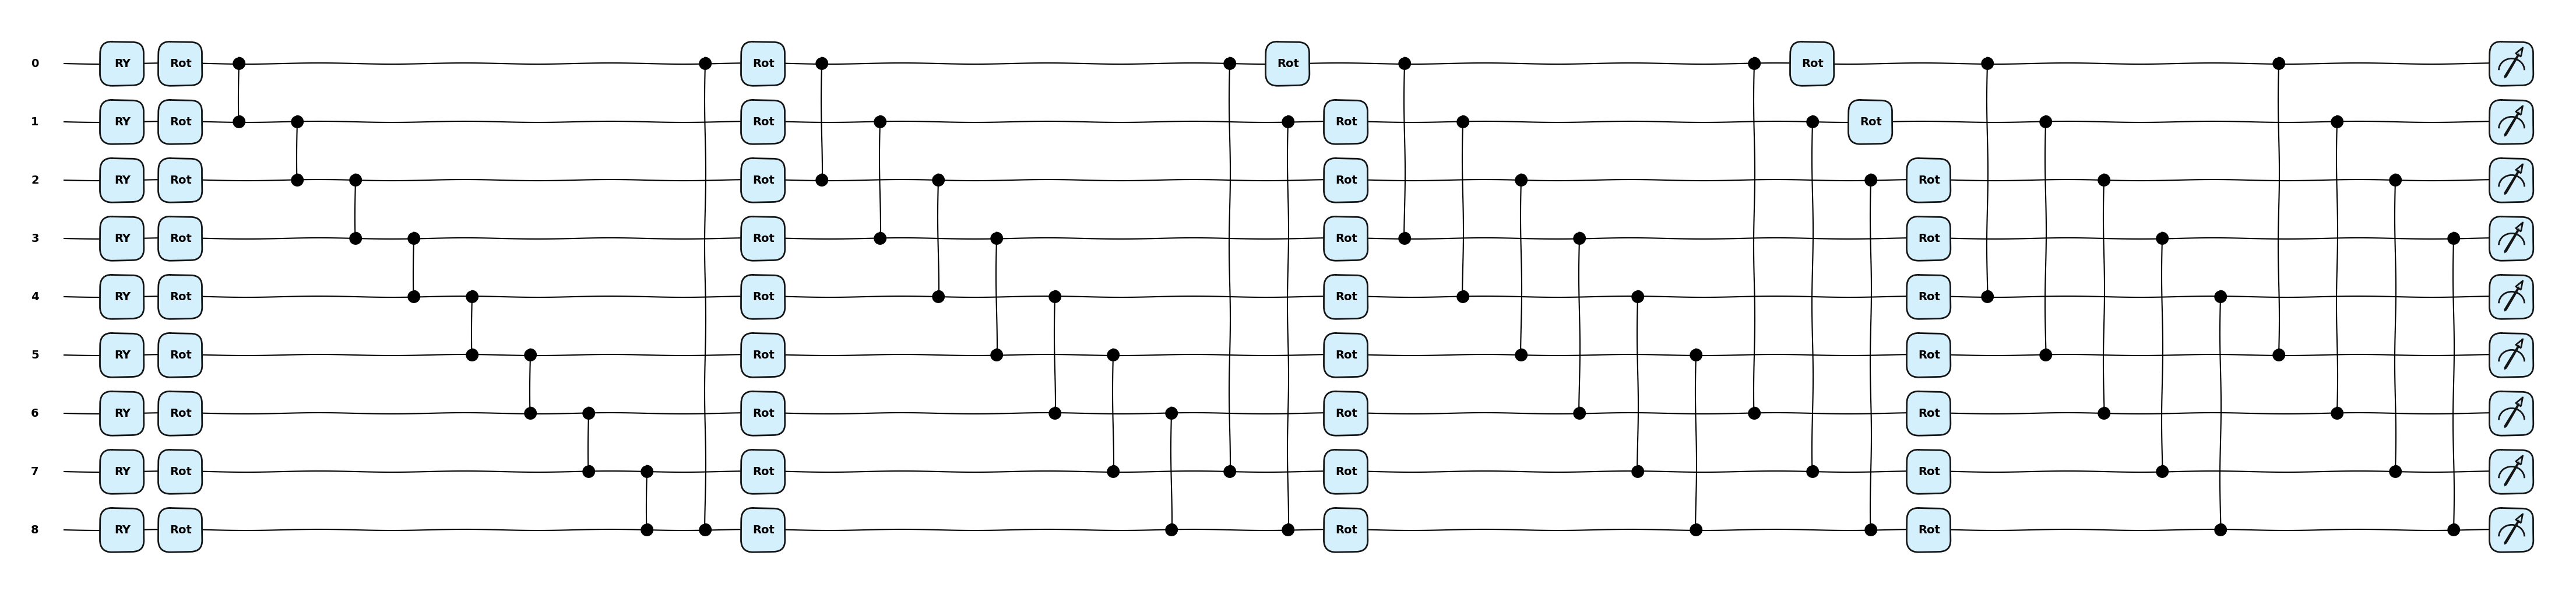

In [ ]:
# Drawing circuit
qml.drawer.use_style('pennylane_sketch')
qml.draw_mpl(circuit, expansion_strategy="device")([i for i in range(n_wires)])

In [ ]:
# A 3x3 kernel with stride = 2
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 9))  # 9 output channels for 3x3 kernel

    # Loop over the coordinates of the top-left pixel of 3x3 squares
    for j in range(0, 26, 2):
        for k in range(0, 26, 2):
            # Process a 3x3 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],     image[j, k+1, 0],     image[j, k+2, 0],
                    image[j+1, k, 0],   image[j+1, k+1, 0],   image[j+1, k+2, 0],
                    image[j+2, k, 0],   image[j+2, k+1, 0],   image[j+2, k+2, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j, k)
            for c in range(len(q_results)):
                out[j//2, k//2, c] = q_results[c]
    return out

In [ ]:
quanv(train_images[0]).shape

(14, 14, 9)

In [ ]:
# to use the image for quantum circuit as convolutional layer
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print(f"{idx+1}/{n_train}")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print(f"{idx+1}/{n_test}")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    q_val_images = []
    print("\nQuantum pre-processing of validation images:")
    for idx, img in enumerate(val_images):
        print(f"{idx+1}/{n_val}")
        q_val_images.append(quanv(img))
    q_val_images = np.asarray(q_val_images)

    # Save pre-processed images
    np.save(root_path + exp_name + "_q_train_images.npy", q_train_images)
    np.save(root_path + exp_name + "_q_test_images.npy", q_test_images)
    np.save(root_path + exp_name + "_q_val_images.npy", q_val_images)

In [ ]:
# Load pre-processed images
q_train_images = np.load(root_path + exp_name + "_q_train_images.npy")
q_test_images = np.load(root_path + exp_name + "_q_test_images.npy")
q_val_images = np.load(root_path + exp_name + "_q_val_images.npy")

In [ ]:
# to handle quantum vs classical data
def handling_cq_data(tr_image, te_image, v_image):
    train_datagen = ImageDataGenerator()
    test_datagen = ImageDataGenerator()
    val_datagen = ImageDataGenerator()

    train_ds = train_datagen.flow(
    tr_image, train_labels,
    batch_size=batch_size)

    test_ds = test_datagen.flow(
    te_image, test_labels,
    shuffle=False,
    batch_size=batch_size)

    val_ds = val_datagen.flow(
    v_image, val_labels,
    shuffle=False,
    batch_size=batch_size)

    return train_ds, test_ds, val_ds

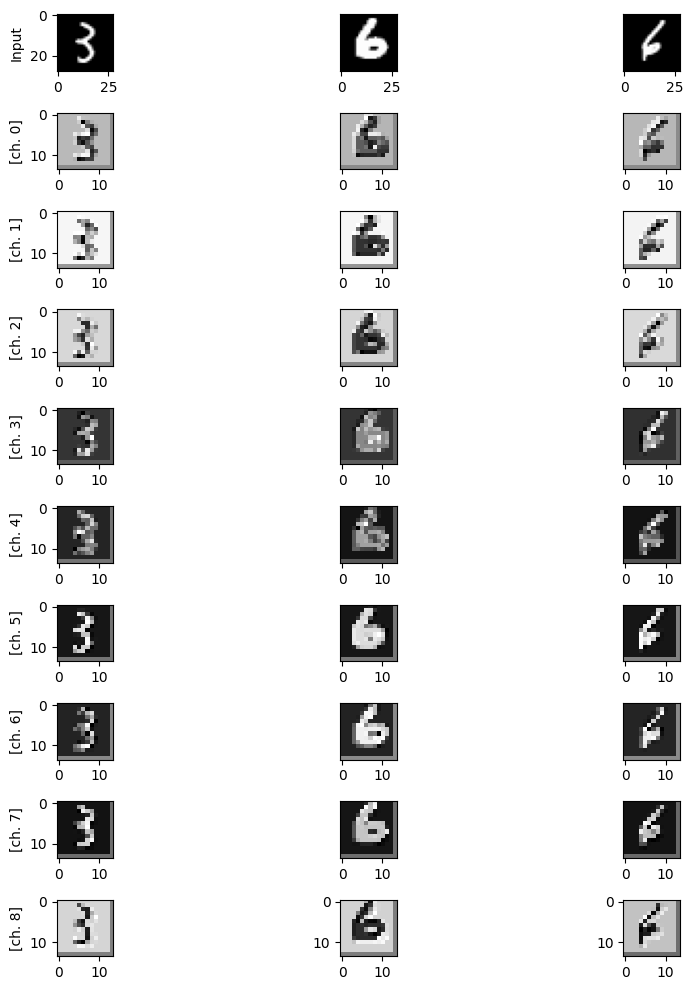

In [ ]:
# visualize images from quantum kernel
n_samples = 3
n_channels = 9
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("[ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

The $9$ output channels generated by the quantum
convolution are visualized in gray scale.


# Hybrid quantum-classical model

After the application of the quantum convolution layer we feed the
resulting features into a classical neural network that will be trained
to classify the $10$ different digits of the MNIST dataset.

A Convolutional 3x3 kernel with 32 channels, followed by a Maxpooling2D 2x2 filter is implemented. A dense layer with 64 nodes is applied before the 10 classifying dense nodes, and a dropout of 50% is imposed in the middle to handle the overfitting issue.


In [ ]:
# Quantum-Classical hybrid model
def MyModelQ():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(14, 14, 9)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        # The model was training too fast, leading to overfitting, that's why a small
        # dropout is imposed.

        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["acc"],
    )
    return model

In [ ]:
# Classical CNN
def MyModelC():

    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D((2, 2)),

        keras.layers.Flatten(),

        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        # The model was training too fast, leading to overfitting, that's why a small
        # dropout is imposed.

        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["acc"],
    )
    return model

In [ ]:
# quantum callbacks
checkpoint_path = f"{root_path}Models/{exp_name}_qmodel.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)
q_callbacks = [
    # To save the best performing model
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       verbose=1,
                                       save_best_only=True,
                                       monitor = 'val_loss',
                                       mode='min'),

    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.8,
                                        patience=3,
                                        cooldown=1,
                                        verbose=1,
                                        mode='auto',
                                        min_lr=1e-4,
                                        min_delta=0.0001),
    CSVLogger(f"{root_path}Models/{exp_name}_qmodel.log", separator=',', append=False)
]

In [ ]:
# classical callbacks
checkpoint_path = f"{root_path}/Models/{exp_name}_cmodel.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)
c_callbacks = [
    # To save the best performing model
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       verbose=1,
                                       save_best_only=True,
                                       monitor = 'val_loss',
                                       mode='min'),

    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.8,
                                        patience=3,
                                        cooldown=1,
                                        verbose=1,
                                        mode='auto',
                                        min_lr=1e-4,
                                        min_delta=0.0001),
    CSVLogger(f"{root_path}Models/{exp_name}_cmodel.log", separator=',', append=False)
]

## Training (Hybrid Model)

---


In [ ]:
train_ds, test_ds, val_ds = handling_cq_data(q_train_images, q_test_images, q_val_images)
q_model = MyModelQ()

q_history = q_model.fit(
    train_ds,
    validation_data = val_ds,
    batch_size=32,
    epochs=n_epochs,
    callbacks=q_callbacks
)

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (350, 14, 14, 9) (9 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (100, 14, 14, 9) (9 channels).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (50, 14, 14, 9) (9 channels).
 

Epoch 1/50
 3/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.0722 - loss: 2.3669

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.1153 - loss: 2.3118
Epoch 1: val_loss improved from inf to 2.11084, saving model to /content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_3/Models/task_3_qmodel.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - acc: 0.1199 - loss: 2.3067 - val_acc: 0.3200 - val_loss: 2.1108 - learning_rate: 0.0010
Epoch 2/50
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.2736 - loss: 2.1125
Epoch 2: val_loss improved from 2.11084 to 1.85882, saving model to /content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_3/Models/task_3_qmodel.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - acc: 0.2902 - loss: 2.0900 - val_acc: 0.6800 - val_loss: 1.8588 - learning_rate: 0.0010
Epoch 3/50
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.3647 - loss: 1.8759
Epoch 3: val_loss improved from 1.85882 to 1.57669, saving model to /content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_3/Models/task_3_qmodel.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms

### Performance Measurements

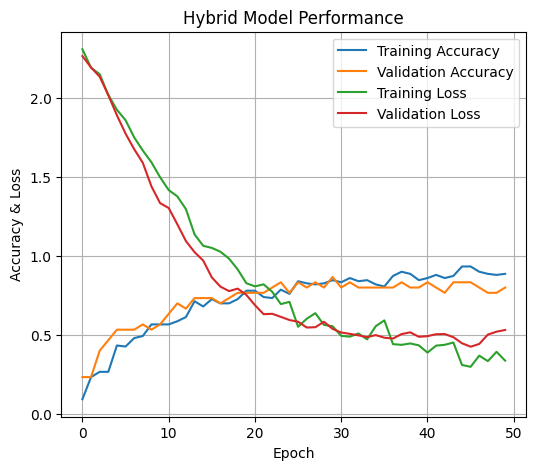

In [ ]:
import keras
import pandas as pd
############ load trained model ################
qcnn_model = keras.models.load_model(f"{root_path}/Models/{exp_name}_qmodel.keras", compile=False)

history = pd.read_csv(f"{root_path}Models/{exp_name}.log", sep=',', engine='python')

############### ########## ####### #######

acc=history['acc']
val_acc=history['val_acc']

loss = history['loss']
val_loss = history['val_loss']


epochs_range=range(len(acc))

plt.figure(figsize=(6, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title("Hybrid Model Performance")
plt.xlabel("Epoch")
plt.ylabel("Accuracy & Loss")
plt.legend()
plt.grid()

plt.savefig(f"{root_path}Figures/{exp_name}_qmodel_acc_loss.jpg", dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
qcnn_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'] )
print("Evaluate on test data")
test_loss, test_acc = qcnn_model.evaluate(test_ds, batch_size=32, callbacks= q_callbacks)
print("test loss: %.2f, test acc: %.2f"%(test_loss, test_acc))

Evaluate on test data
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8770 - loss: 0.3567  
test loss: 0.33, test acc: 0.88


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
labels_pred= q_model.predict(test_ds)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [ ]:
from collections import Counter
y_pred = tf.argmax(labels_pred, axis=1)


In [ ]:
y_true = tf.argmax(test_labels, axis = 1)

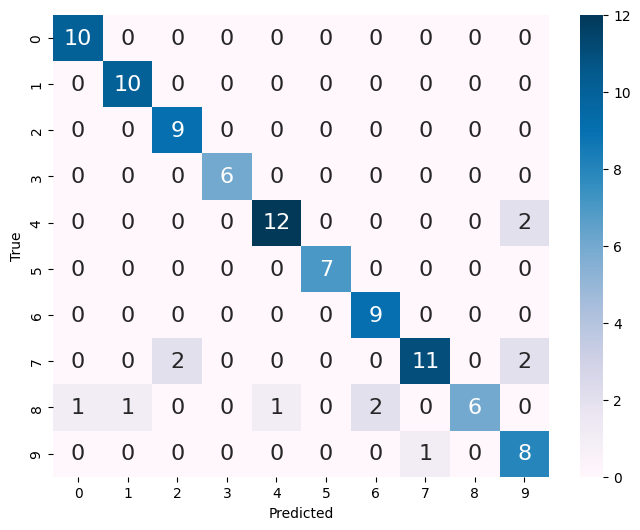

In [ ]:
confusion = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion)
df_cm.index.name = 'True'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8, 6))
# sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="PuBu", annot=True,annot_kws={"size": 16}, fmt='d')

plt.savefig(f"{root_path}Figures/{exp_name}_qmodel_CM.jpg", bbox_inches='tight', dpi=500)
plt.show()
# plt.close()

In [ ]:
# On 100 testing set
# Calculate overall accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Calculate Cohen's kappa (Kappa)
kappa = cohen_kappa_score(y_true, y_pred)

# Calculate average accuracy (AA)
accuracies = []
for i in range(len(Counter(np.array(y_pred)))):
    accuracies.append(accuracy_score(y_true[y_true==i], y_pred[y_true==i]))
aa = sum(accuracies) / len(accuracies)

# # Matthew’s correlation coefficient
# print("Matthew’s correlation coefficient: %.3f"%matthews_corrcoef(y_true, y_pred))


print("Overall Accuracy (OA): {:.2f}%".format(oa*100))
print("Cohen's Kappa: {:.4f}%".format(kappa*100))
print("Average Accuracy (AA): {:.2f}%".format(aa.mean()*100))

Overall Accuracy (OA): 88.00%
Cohen's Kappa: 86.6086%
Average Accuracy (AA): 90.25%


## Training (Classical Model)
---

In [ ]:
train_ds, test_ds, val_ds = handling_cq_data(train_images, test_images, val_images)
c_model = MyModelC()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    batch_size=32,
    epochs=n_epochs,
    callbacks = c_callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.1937 - loss: 2.2156
Epoch 1: val_loss improved from inf to 1.83212, saving model to /content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_3//Models/task_3_cmodel.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - acc: 0.2153 - loss: 2.1915 - val_acc: 0.5000 - val_loss: 1.8321 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.5099 - loss: 1.6590
Epoch 2: val_loss improved from 1.83212 to 1.43252, saving model to /content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_3//Models/task_3_cmodel.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.5095 - loss: 1.6539 - val_acc: 0.6200 - val_loss: 1.4325 - learning_rate: 0.0010
Epoch 3/50
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.6826 - loss: 1.1247
Epoch 3: val_loss improved from 1.43252 to 1.08484, saving model to /content/drive/MyDrive/Womanium Quantum+AI 2024/QML/Codes/task_3//Models/task_3_cmodel.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32

### Performance Measurements

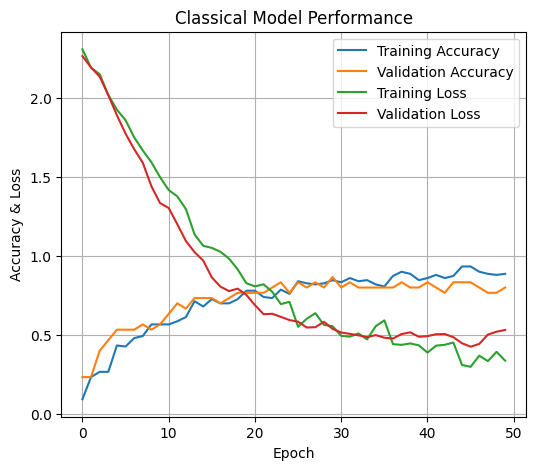

In [ ]:
import keras
import pandas as pd
############ load trained model ################
ccnn_model = keras.models.load_model(f"{root_path}Models/{exp_name}_cmodel.keras", compile=False)

history = pd.read_csv(f"{root_path}Models/{exp_name}.log", sep=',', engine='python')

############### ########## ####### #######

acc=history['acc']
val_acc=history['val_acc']

loss = history['loss']
val_loss = history['val_loss']


epochs_range=range(len(acc))

plt.figure(figsize=(6, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title("Classical Model Performance")
plt.xlabel("Epoch")
plt.ylabel("Accuracy & Loss")
plt.legend()
plt.grid()

plt.savefig(f"{root_path}Figures/{exp_name}_cmodel_acc_loss.jpg", dpi=500, bbox_inches='tight')
plt.show()

In [ ]:
ccnn_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'] )
print("Evaluate on test data")
test_loss, test_acc = ccnn_model.evaluate(test_ds, batch_size=32, callbacks= c_callbacks)
print("test loss: %.2f, test acc: %.2f"%(test_loss, test_acc))

Evaluate on test data
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8645 - loss: 0.5500  
test loss: 0.46, test acc: 0.88


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
labels_pred= c_model.predict(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [ ]:
from collections import Counter
y_pred = tf.argmax(labels_pred, axis=1)


In [ ]:
y_true = tf.argmax(test_labels, axis = 1)

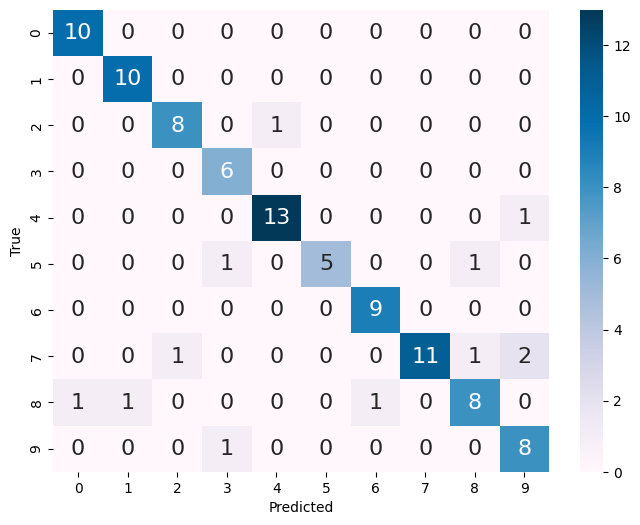

In [ ]:
confusion = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(confusion)
df_cm.index.name = 'True'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8, 6))
# sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="PuBu", annot=True,annot_kws={"size": 16}, fmt='d')

plt.savefig(f"{root_path}Figures/{exp_name}_cmodel_CM.jpg", bbox_inches='tight', dpi=500)
plt.show()

In [ ]:
# On 100 testing set
# Calculate overall accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Calculate Cohen's kappa (Kappa)
kappa = cohen_kappa_score(y_true, y_pred)

# Calculate average accuracy (AA)
accuracies = []
for i in range(len(Counter(np.array(y_pred)))):
    accuracies.append(accuracy_score(y_true[y_true==i], y_pred[y_true==i]))
aa = sum(accuracies) / len(accuracies)

# # Matthew’s correlation coefficient
# print("Matthew’s correlation coefficient: %.3f"%matthews_corrcoef(y_true, y_pred))


print("Overall Accuracy (OA): {:.2f}%".format(oa*100))
print("Cohen's Kappa: {:.4f}%".format(kappa*100))
print("Average Accuracy (AA): {:.2f}%".format(aa.mean()*100))

Overall Accuracy (OA): 88.00%
Cohen's Kappa: 86.6012%
Average Accuracy (AA): 88.81%


## Model Comparison
---

Validation accuracy vs validation loss on validation data in classical vs quantum model while training.

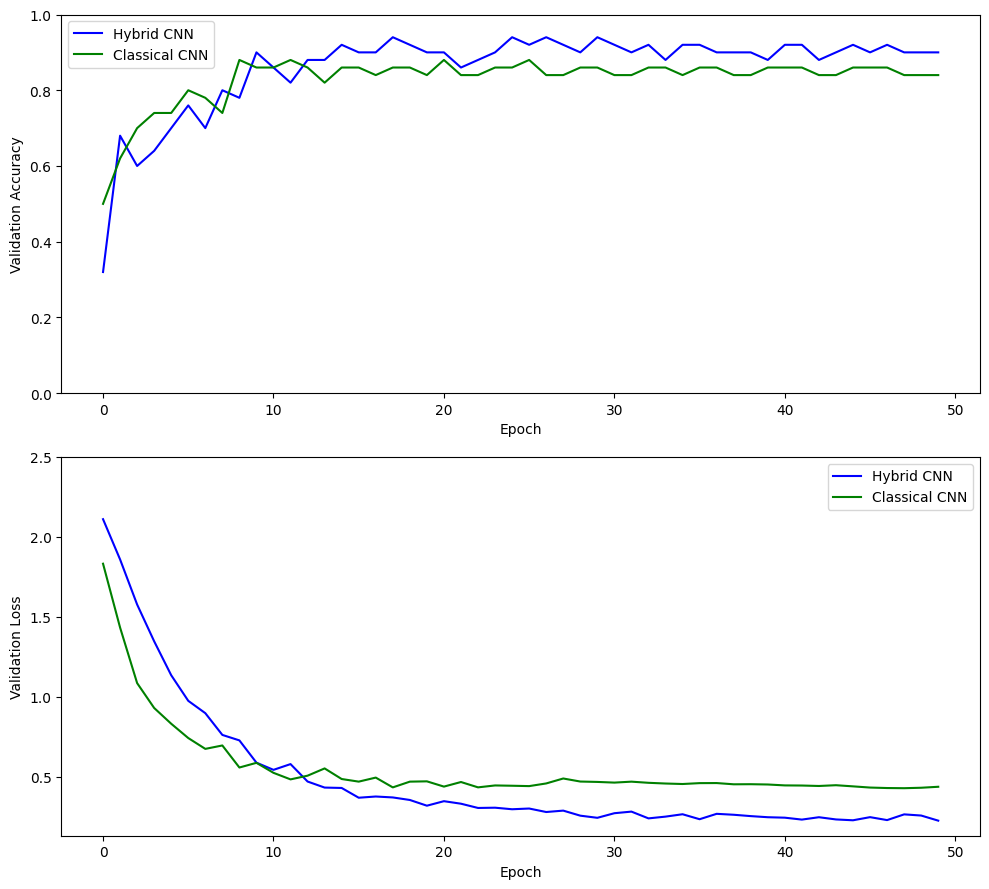

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 9))

ax1.plot(q_history.history["val_acc"], "b", label="Hybrid CNN")
ax1.plot(c_history.history["val_acc"], "g", label="Classical CNN")
ax1.set_ylabel("Validation Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "b", label="Hybrid CNN")
ax2.plot(c_history.history["val_loss"], "g", label="Classical CNN")
ax2.set_ylabel("Validation Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.savefig(f"{root_path}Figures/{exp_name}_model_comparison.jpg", bbox_inches='tight', dpi=500)
plt.show()

# References
---
- [Quanvolutional Neural Networks](https://pennylane.ai/qml/demos/tutorial_quanvolution/) by Andrea Mari

**By -**

Name: Asadullah Bin Rahman

Email: [galib.cse.17020221@std.hstu.ac.bd](galib.cse.17020221@std.hstu.ac.bd)

[Portfolio](https://asadullahgalib007.github.io/), [LinkedIn](https://www.linkedin.com/in/asadullah-bin-rahman/), [Google Scholar](https://scholar.google.com/citations?user=mhuUG2oAAAAJ&hl=en)